In [2]:
import heapq
import time
import matplotlib.pyplot as plt

class Nodo:
    def __init__(self, estado, padre, accion):
        self.estado = estado
        self.padre = padre
        self.accion = accion

class Frontera:
    def __init__(self, tipo):
        self.tipo = tipo
        self.contador = 0
        self.frontera = [] 
    def empty(self):
        return len(self.frontera) == 0
    def add(self, nodo, prioridad=0):
        if self.tipo == "A*":
            heapq.heappush(self.frontera, (prioridad, self.contador, nodo))
            self.contador += 1
        else:
            self.frontera.append(nodo)

    def eliminar(self):
        if self.empty():
            raise Exception("Frontera vacía")
        if self.tipo == "LIFO":
            return self.frontera.pop()
        elif self.tipo == "FIFO":
            return self.frontera.pop(0)
        elif self.tipo == "A*":
            return heapq.heappop(self.frontera)[2]

    def contiene_estado(self, estado):
        if self.tipo == "A*":
            return any(nodo.estado == estado for _, _, nodo in self.frontera)
        else:
            return any(nodo.estado == estado for nodo in self.frontera)

def heuristica_manhattan(estado, objetivo):
    x1, y1 = estado
    x2, y2 = objetivo
    return abs(x1 - x2) + abs(y1 - y2)


class Laberinto:
    def __init__(self, filename):
        with open(filename) as file:
            contenido = file.read()
        if contenido.count("A") != 1 or contenido.count("B") != 1:
            raise Exception("El laberinto debe tener un inicio y un objetivo")
        contenido = contenido.splitlines()
        self.altura = len(contenido)
        self.ancho = max(len(line) for line in contenido)
        self.muros = []
        for i in range(self.altura):
            fila = []
            for j in range(self.ancho):
                try:
                    char = contenido[i][j]
                    if char == "A":
                        self.inicio = (i, j)
                        fila.append(False)
                    elif char == "B":
                        self.objetivo = (i, j)
                        fila.append(False)
                    elif char == " ":
                        fila.append(False)
                    else:
                        fila.append(True)
                except IndexError:
                    fila.append(False)
            self.muros.append(fila)
        self.solucion = None

    def vecinos(self, estado):
        fila, col = estado
        candidatos = [
            ("Arriba", (fila - 1, col)),
            ("Abajo", (fila + 1, col)),
            ("Izquierda", (fila, col - 1)),
            ("Derecha", (fila, col + 1))
        ]
        return [(a, (f, c)) for a, (f, c) in candidatos if 0 <= f < self.altura and 0 <= c < self.ancho and not self.muros[f][c]]

    def print(self):
        sol = self.solucion[1] if self.solucion else None
        for i, fila in enumerate(self.muros):
            for j, muro in enumerate(fila):
                if muro:
                    print("█", end="")
                elif (i, j) == self.inicio:
                    print("A", end="")
                elif (i, j) == self.objetivo:
                    print("B", end="")
                elif sol and (i, j) in sol:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()

    def solve(self, metodo="LIFO"):
        self.num_explorados = 0
        inicio = Nodo(estado=self.inicio, padre=None, accion=None)
        frontera = Frontera(metodo)
        frontera.add(inicio, 0 if metodo == "A*" else None)
        self.explorado = set()

        while True:
            if frontera.empty():
                raise Exception("No hay solución")
            nodo = frontera.eliminar()
            self.num_explorados += 1
            if nodo.estado == self.objetivo:
                acciones = []
                celdas = []
                while nodo.padre:
                    acciones.append(nodo.accion)
                    celdas.append(nodo.estado)
                    nodo = nodo.padre
                acciones.reverse()
                celdas.reverse()
                self.solucion = (acciones, celdas)
                return

            self.explorado.add(nodo.estado)
            for accion, estado in self.vecinos(nodo.estado):
                if not frontera.contiene_estado(estado) and estado not in self.explorado:
                    hijo = Nodo(estado, nodo, accion)
                    if metodo == "A*":
                        prioridad = len(self.explorado) + heuristica_manhattan(estado, self.objetivo)
                        frontera.add(hijo, prioridad)
                    else:
                        frontera.add(hijo)

In [3]:
if __name__ == "__main__":
    metodo = "A*"  # Opciones: "FIFO", "LIFO", "A*"
    archivo = "laberintos/laberinto3.txt"  # 

    lab = Laberinto(archivo)
    print("Laberinto original:")
    lab.print()
    print(f"Resolviendo con {metodo}...\n")
    lab.solve(metodo)
    print(f"Explorados: {lab.num_explorados}")
    print("Solución encontrada:")
    lab.print()


Laberinto original:
A ████████  
    █     █ 
█ █ █ ███ █ 
█ █   █   █ 
█ █████ ███ 
█     █   █ 
███ ███ ███ 
█   █     █ 
█ ███ █████ 
█       B █ 
███████████ 

Resolviendo con A*...

Explorados: 32
Solución encontrada:
A ████████  
**  █     █ 
█*█ █ ███ █ 
█*█   █   █ 
█*█████ ███ 
█***  █   █ 
███*███ ███ 
█***█     █ 
█*███ █████ 
█*******B █ 
███████████ 



In [ ]:
metodos = ["FIFO", "LIFO", "A*"]
resultados = {metodo: [] for metodo in metodos}
archivos = [f"laberintos/laberinto{i}.txt" for i in range(1, 11)]
for metodo in metodos:
    print(f"\n Método: {metodo}")
    for archivo in archivos:
        inicio_tiempo = time.time()
        lab = Laberinto(archivo)
        lab.solve(metodo=metodo)
        duracion = time.time() - inicio_tiempo
        resultados[metodo].append(duracion)
        print(f"{archivo} -> {duracion:.4f} segundos")

print("\n Resultados:")
for metodo in metodos:
    tiempos = resultados[metodo]
    print(f"{metodo}: Promedio = {sum(tiempos)/len(tiempos):.4f}s, Total = {sum(tiempos):.4f}s")




 Método: FIFO
laberintos/laberinto1.txt -> 0.0018 segundos
laberintos/laberinto2.txt -> 0.0103 segundos
laberintos/laberinto3.txt -> 0.0322 segundos
laberintos/laberinto4.txt -> 0.0324 segundos
laberintos/laberinto5.txt -> 0.0356 segundos
laberintos/laberinto6.txt -> 0.0652 segundos
laberintos/laberinto7.txt -> 0.0335 segundos
laberintos/laberinto8.txt -> 0.0177 segundos
laberintos/laberinto9.txt -> 0.0106 segundos
laberintos/laberinto10.txt -> 0.0237 segundos

 Método: LIFO
laberintos/laberinto1.txt -> 0.0028 segundos
laberintos/laberinto2.txt -> 0.0092 segundos
laberintos/laberinto3.txt -> 0.0010 segundos
laberintos/laberinto4.txt -> 0.0020 segundos
laberintos/laberinto5.txt -> 0.0025 segundos
laberintos/laberinto6.txt -> 0.0024 segundos
laberintos/laberinto7.txt -> 0.0131 segundos
laberintos/laberinto8.txt -> 0.0123 segundos
laberintos/laberinto9.txt -> 0.0169 segundos
laberintos/laberinto10.txt -> 0.0085 segundos

 Método: A*
laberintos/laberinto1.txt -> 0.0007 segundos
laberintos

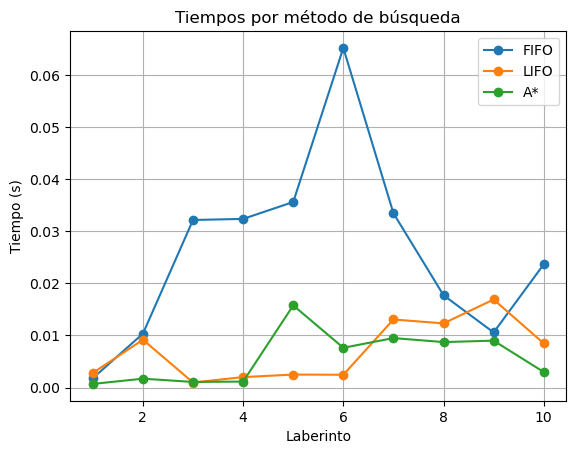

In [6]:
for metodo in metodos:
    plt.plot(range(1, 11), resultados[metodo], marker='o', label=metodo)

plt.title("Tiempos por método de búsqueda")
plt.xlabel("Laberinto")
plt.ylabel("Tiempo (s)")
plt.legend()
plt.grid(True)
plt.show()
